<h1 style="color:cornflowerblue">Objectives</h1>
<p>For this case, consider that the current company is trying classify products that will be sold.</p>
<p>This study aims on the correct classification of fruits and vegetables, to avoid human error in the operation.</p>
<p>For testing the solution first, the model must correctly classify potatoes, carrots, tomatoes and lemons.</p>
<p>Images were downloaded from google to create a database of images.</p>

<h1 style="color:cornflowerblue">Importing Libraries</h1>

In [1]:
# General Libraries
import time
import os
import PIL.Image
import numpy as np
import shutil

# Data Manipulation
import torch, torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from IPython.display import Image

# Data Visualization
from matplotlib import pyplot as plt

# Model Deploy
import gradio as gr

<h1 style="color:cornflowerblue">Separating Image Bases</h1>
<p>First the image base (raw) will be separated in Train, Validation and Test

In [2]:
# Original images base directory
raw_img = "./data/raw"

# List of folders (products)
folders_img = os.listdir(raw_img)
folders_img

['carrot', 'lemon', 'potato', 'tomato']

In [3]:
# Dictionary of products and imagens
prod_count_img = {folder : len(os.listdir(os.path.join(raw_img, folder))) for folder in os.listdir(raw_img)}
prod_count_img

{'carrot': 181, 'lemon': 111, 'potato': 146, 'tomato': 107}

In [4]:
# Processed images base directory
process_img = "./data/processed/"

# Processed folders for the train, validation and test bases
path_train = os.path.join(process_img, "train/")
path_validation = os.path.join(process_img, "validation/")
path_test = os.path.join(process_img, "test/")

# Creating folders
if not os.path.exists(path_train):
    os.makedirs(path_train)

if not os.path.exists(path_validation):
    os.makedirs(path_validation)

if not os.path.exists(path_test):
    os.makedirs(path_test)

In [5]:
# Creating products folders in train, validation and test folders

for products in list(prod_count_img):
    dir_train = os.path.join(path_train, products)
    dir_val = os.path.join(path_validation, products)
    dir_test = os.path.join(path_test, products)
    
    if not os.path.exists(dir_train):
        os.makedirs(dir_train)
    if not os.path.exists(dir_val):
        os.makedirs(dir_val)
    if not os.path.exists(dir_test):
        os.makedirs(dir_test)

    # Base path of the raw images
    base_path = os.path.join(raw_img, products)

    # List all files in the product raw folder
    prod_list = os.listdir(base_path)

    # Separating 80% for train and 20% for validation+test
    train_base, val_test = train_test_split(prod_list,
                                           shuffle=True,
                                           test_size=0.2,
                                           random_state=42)
    
    # Separating validation and test with 10% of the original base
    val_base, test_base = train_test_split(val_test,
                                           shuffle=True,
                                           test_size=0.5,
                                           random_state=42)
    
    # no need for the temporary list
    del val_test

    # Checking values
    print(products)
    print(f"Train Base: {len(train_base)}")
    print(f"Validation Base: {len(val_base)}")
    print(f"Test Base: {len(test_base)}")
    print(f"Total Base: {len(prod_list)}\n")

    #Copying files
    for images in train_base:
        origin_path = os.path.join(raw_img, products, images)
        final_path = os.path.join(dir_train, images)
        shutil.copy(origin_path, final_path)
    
    for images in val_base:
        origin_path = os.path.join(raw_img, products, images)
        final_path = os.path.join(dir_val, images)
        shutil.copy(origin_path, final_path)

    for images in test_base:
        origin_path = os.path.join(raw_img, products, images)
        final_path = os.path.join(dir_test, images)
        shutil.copy(origin_path, final_path)


carrot
Train Base: 144
Validation Base: 18
Test Base: 19
Total Base: 181

lemon
Train Base: 88
Validation Base: 11
Test Base: 12
Total Base: 111

potato
Train Base: 116
Validation Base: 15
Test Base: 15
Total Base: 146

tomato
Train Base: 85
Validation Base: 11
Test Base: 11
Total Base: 107



<h1 style="color:cornflowerblue">Pre Processing</h1>
<p>Starting To preprocees images for using PyTorch.</p>
<p>Creating the transformations to resize the images, transforming them in Tensors in PyTorch.

In [6]:
# Image Sizes
img_size = 100

# For better results, not only augment the image, but also resize it, rotate, mirror and random crops.
# For this case, it will only be done an image resizing.
# Also, normally all this processes are done only in the train base.

img_transformation = {
    "train": transforms.Compose([
        transforms.Resize(size=[img_size, img_size]),
        transforms.ToTensor(),]),
    "validation": transforms.Compose([
        transforms.Resize(size=[img_size, img_size]),
        transforms.ToTensor(),]),
    "test": transforms.Compose([
        transforms.Resize(size=[img_size, img_size]),
        transforms.ToTensor(),]),
}

<h2 style="color:cornflowerblue">Preparing for Training</h2>

In [7]:
# Batch of training (will train on groups)
train_batch = 8

# Number of classes that the model will use
class_num = len(os.listdir(path_train))
class_num

4

In [8]:
# Loading images using datasets from torchvision
img_data = {
    "train": datasets.ImageFolder(root=path_train, transform=img_transformation["train"]),
    "validation": datasets.ImageFolder(root=path_validation, transform=img_transformation["validation"])
}

img_data

{'train': Dataset ImageFolder
     Number of datapoints: 433
     Root location: ./data/processed/train/
     StandardTransform
 Transform: Compose(
                Resize(size=[100, 100], interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ),
 'validation': Dataset ImageFolder
     Number of datapoints: 55
     Root location: ./data/processed/validation/
     StandardTransform
 Transform: Compose(
                Resize(size=[100, 100], interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            )}

In [9]:
# Mapping and indexing classes
# class_dict = {list(prod_count_img).index(class_name): class_name for class_name in list(prod_count_img)}
class_dict = {class_index: class_name for class_name, class_index in img_data["train"].class_to_idx.items()}
class_dict

{0: 'carrot', 1: 'lemon', 2: 'potato', 3: 'tomato'}

In [10]:
# Images used to calculate mean error and accuracy
train_img_num = len(img_data["train"])
validation_img_num = len(img_data["validation"])

train_img_num, validation_img_num

(433, 55)

In [11]:
# Creating dataloaders (responsible for organizing the data for the training of the neural network)
train_data_loader = DataLoader(dataset=img_data["train"], batch_size=train_batch, shuffle=True)
validation_data_loader = DataLoader(dataset=img_data["validation"], batch_size=train_batch, shuffle=True)

<h3 style="color:cornflowerblue">Checking Images</h3>
<p>Visualization of images from the train base for each of the classes</p>

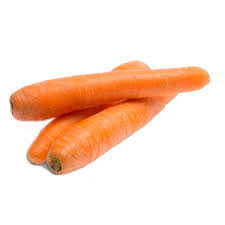

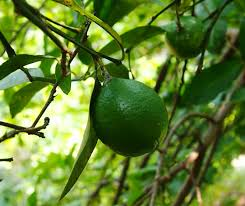

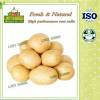

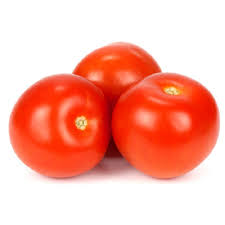

In [12]:
# Show some images
for classes in class_dict.values():
    class_path = os.path.join(path_train, classes)
    img_file = os.listdir(class_path)[1]
    img = Image(filename=os.path.join(class_path, img_file))
    display(img)

<h1 style="color:cornflowerblue">Transfer Learning</h1>
<p>For this, the Neural Network used is going to be Alexnet, a pre-trained Neural Network with a excellent classification score among neural networks.

In [13]:
# Instancing the Alexnet Neural Network (The pretrained version)
al_model = models.alexnet(weights="AlexNet_Weights.DEFAULT")

al_model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [14]:
# The pretrained model must not relearn or retrain from scratch
# It must use its parameters and only change the last/final layer from the Neural Network
# To freeze the training and update of the model with new inputs (and the change of coeficients) every parameter must change its requires_grad to False
for param in al_model.parameters():
    param.requires_grad = False

In [15]:
# Checking the Last Layer of the Neural Network
# al_model.classifier[-1]
al_model.classifier[6]

Linear(in_features=4096, out_features=1000, bias=True)

In [16]:
# Changing the last layer of the Neural Network for the number of class needed
al_model.classifier[6] = nn.Linear(in_features=4096, out_features=class_num)

# Add softmax module so that the probability of one of the classes is 1
al_model.classifier.add_module("7", nn.LogSoftmax(dim = 1))

al_model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [17]:
# Checking the last layer (requires_grad must be true to this layer)
# This way the model will be trained with the data needed to be classified
for param in al_model.classifier[6].parameters():
    print(param)

Parameter containing:
tensor([[-0.0069,  0.0112, -0.0053,  ...,  0.0139, -0.0023, -0.0148],
        [ 0.0094,  0.0035,  0.0137,  ...,  0.0002, -0.0016, -0.0059],
        [-0.0098,  0.0038, -0.0048,  ..., -0.0080,  0.0151,  0.0023],
        [-0.0018, -0.0002,  0.0052,  ...,  0.0067,  0.0031,  0.0091]],
       requires_grad=True)
Parameter containing:
tensor([0.0079, 0.0106, 0.0149, 0.0077], requires_grad=True)


<h2 style="color:cornflowerblue">Optimization</h2>

<h2 style="color:cornflowerblue">Evaluation Metric</h2>
<p>For this case the metric used will be the Cross Entropy Loss - Mostly used for Classification Problems.</p>
<p>This metric will care for the correct classification but also for it`s prediction difference to other classes. If the model classify one image as a specific class as 49% of chance and the second class gets a chance of 48%, it will penalize that prediction.</p>

In [18]:
# Instancing the error function with Cross Entropy Loss
error_func = nn.CrossEntropyLoss()

<h2 style="color:cornflowerblue">Optimizer</h2>
<p>It changes the weight of the network, according to a specific algorithm.</p>
<p>For this case the Adam Optimizer will be used (the Stochastic Gradient Descent could be used as well).</p>

In [19]:
# Instancing the Optimizer
optimizer = optim.Adam(al_model.parameters())
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

<h2 style="color:cornflowerblue">Train and Validation</h2>
<p>In the train part the model will accomplish several steps forward (prediction) and backward (back propagation, learning with error). At each part, all images from train will be used to optimize the parameters of the Neural Network. Inside each part, the training by batch of images is used instead of one single image at a time.</p>
<p>In the validation part, the gradient calculation is not used, since backpropagaton won't be used for this case.</p>


In [20]:
def train_and_validate(model, error_metric, optimizer, epochs=10):
    '''
    Function to Train and Validate the model:
    
    Parameters:
        model: model to train and validate
        metric: criteria for error miminization
        optimizer: optimizer to get better parameters out of the Neural Network
        epochs: number of epochs (default=10)

    Returns:
        best_model: model trained with the meste accuracy in the validation
        history: history with the error in the train and validation
    '''

    # Instancing history, best accuracy metric and best model according to validation
    history = []
    best_acc = 0.0
    best_model = None

    # Checking the device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)


    # In each epoch the modell will go through all images from train and calculate the error of train and validation.
    for epoch in range(epochs):
        start_epoch = time.time()
        # print("\n\nEpoch: {}/{}".format(epoch +1, epochs))

    # Train error and accuracy
        train_error = 0.0
        train_right = 0.0

    # Validation error and accuracy
        val_error = 0.0
        val_right = 0.0

        # Iterate each image batch
        for i, (img_batch, y_real) in enumerate(train_data_loader):
            
            # print(f"\nLote: {i+1}")
            
            # Using GPU and/or CPU, depending on the hardware and pytorch
            img_batch = img_batch.to(device)
            y_real = y_real.to(device)

            # Clean gradients and gradients
            optimizer.zero_grad()

            # Forward pass - Calculating the output using the model
            # Since the batch has 8 images, 8 predictions will be made
            predictions = model(img_batch)

            
            '''# Tensor with 8 images
            print("\nImage Batch Size:\n", img_batch.size()) 

            # Tensor with 8 predictions, each with 4 values of log probability
            print("\nPredictions:\n", predictions)

            # Converting to exponencial for real probability values
            print("\nPredictions (exp):\n", torch.exp(predictions)) 

            # Shows the maximum predicted value of each image, ant its class index
            print("\nPredictions (torch.max):\n", torch.max(predictions.data, 1))
            print("\nPredictions (torch.max[0]):\n", torch.max(predictions.data, 1)[0])
            print("\nPredictions (torch.max[1]):\n", torch.max(predictions.data, 1)[1])

            # Checking real values
            print("\nReal Values:\n", y_real)

            # Checking the images of the batch
            for i in range(train_batch):
                img_tensor = transforms.ToPILImage()
                img = img_tensor(img_batch[i])
                print(f"\nReal Class: {class_dict[y_real.tolist()[i]]}")
                print(f"Predicted Class:{class_dict[torch.max(predictions.data, 1)[1].tolist()[i]]}")
                display(img)

            break'''
            # If the string is removed, also remove the # on the second break


            # Calculate the error of the output of the forward pass
            # Compare (predict vs real)
            # Return the error mean (batch of 8)
            error = error_metric(predictions, y_real)

            # Backpropagation is the union of the error.backward() + optimizer.step()
            
            # error.backward() calculates the gradients (or the direction of the coeficients to minimize the error)
            error.backward()

            # optimizer.step() updates the coeficients according with the gradients calculated
            optimizer.step()

            # Calculate the total error of the batch, adding the sum of the error in the train
            # The calculated error is the mean of the bath, so it must be multiplied by the batch size
            train_error += error.item() * img_batch.size(0)

        # break
    
            # Number of right predictions
            predict_class = torch.max(predictions.data, 1)[1]
            predictions_right = (predict_class == y_real).type(torch.FloatTensor)

            # Batch right predictions
            batch_right = torch.mean(predictions_right)

            # Number of right prediction in the train base  
            train_right += torch.sum(predictions_right)

            # print("Train - Batch number {:03d}, Error: {:.4f}, Accuracy: {:.4f}".format(i, error.item(), batch_right.item()))
        
        # Validation - not necessary to track the gredients since the model will not be trained with validation. 
        # autograd off
        with torch.no_grad():

            # Changing from train to validation
            model.eval()

            # Validation iteration
            for j, (img_batch, y_real) in enumerate(validation_data_loader):
                img_batch = img_batch.to(device)
                y_real = y_real.to(device)
            
                # Validation forward passa
                predictions = model(img_batch)

                # Validation error
                error = error_metric(predictions, y_real)

                # Validation error + valid_loss
                val_error += error.item() * img_batch.size(0)

                # Number of right predictions
                predict_class = torch.max(predictions.data, 1)[1]
                predictions_right = (predict_class == y_real).type(torch.FloatTensor)

                # Batch right predictions
                batch_right = torch.mean(predictions_right)

                # Number of right prediction in the train base  
                val_right += torch.sum(predictions_right)

                # print("Train - Batch number {:03d}, Error: {:.4f}, Accuracy: {:.4f}".format(j, error.item(), batch_right.item()))
        
        # break

        # Calculating the mean error and train accuracy       
        train_mean_error = train_error / train_img_num
        train_mean_acc = train_right / train_img_num

        # Calculating the mean error and train accuracy       
        val_mean_error = val_error / validation_img_num
        val_mean_acc = val_right / validation_img_num

        # Include the errors and accuracy in the history
        history.append([train_mean_error, val_mean_error, train_mean_acc, val_mean_acc])

        end_epoch = time.time()

        print("Epoch : {:03d}\n- Train: \nError: {:.4f} \nAccuracy: {:.4f}% \n- Validação: \nError : {:.4f} \nAccuracy: {:.4f}% \nTime: {:.4f}s\n".format(epoch+1, train_mean_error, train_mean_acc*100, val_mean_error, val_mean_acc*100, end_epoch-start_epoch))

        # Check if this model accuracy in the validation is the best in that epoch
        # if it is the best, save in the best model and best accuracy
        if val_mean_acc > best_acc:
            best_acc = val_mean_acc
            # torch.save(model, "./model/best_model.pt")
            best_model = model

    return best_model, history

In [21]:
# Defining the number of epochs
epoch_num = 10

# Training the model
trained_model, history = train_and_validate(al_model, error_func, optimizer, epoch_num)

cpu
Epoch : 001
- Train: 
Error: 0.3051 
Accuracy: 88.6836% 
- Validação: 
Error : 0.1356 
Accuracy: 94.5455% 
Time: 2.6028s

Epoch : 002
- Train: 
Error: 0.0575 
Accuracy: 97.2286% 
- Validação: 
Error : 0.0278 
Accuracy: 100.0000% 
Time: 2.3848s

Epoch : 003
- Train: 
Error: 0.0087 
Accuracy: 100.0000% 
- Validação: 
Error : 0.0442 
Accuracy: 98.1818% 
Time: 2.3878s

Epoch : 004
- Train: 
Error: 0.0042 
Accuracy: 100.0000% 
- Validação: 
Error : 0.0397 
Accuracy: 98.1818% 
Time: 2.4840s

Epoch : 005
- Train: 
Error: 0.0033 
Accuracy: 100.0000% 
- Validação: 
Error : 0.0359 
Accuracy: 98.1818% 
Time: 2.6266s

Epoch : 006
- Train: 
Error: 0.0025 
Accuracy: 100.0000% 
- Validação: 
Error : 0.0468 
Accuracy: 98.1818% 
Time: 2.8084s

Epoch : 007
- Train: 
Error: 0.0023 
Accuracy: 100.0000% 
- Validação: 
Error : 0.0437 
Accuracy: 98.1818% 
Time: 2.8450s

Epoch : 008
- Train: 
Error: 0.0015 
Accuracy: 100.0000% 
- Validação: 
Error : 0.0449 
Accuracy: 98.1818% 
Time: 2.6032s

Epoch : 009
-

<h3 style="color:cornflowerblue">Train and Validation History</h3>
<p>Evaluation of the evolution of training and validation</p>

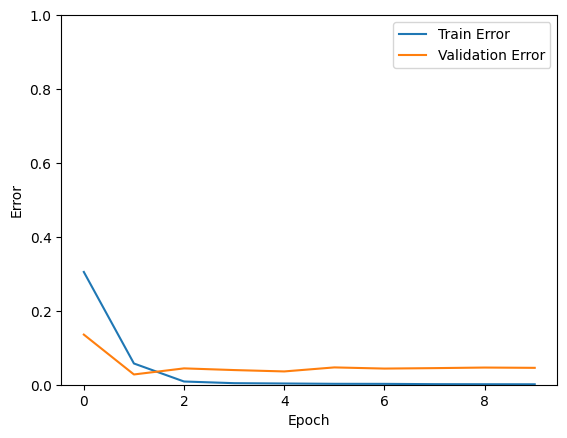

In [22]:
# Show the error in the Training and Validation for each epoch
history = np.array(history)

plt.plot(history[:, 0:2])
plt.legend(["Train Error", "Validation Error"])
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.ylim(0,1)
plt.show()

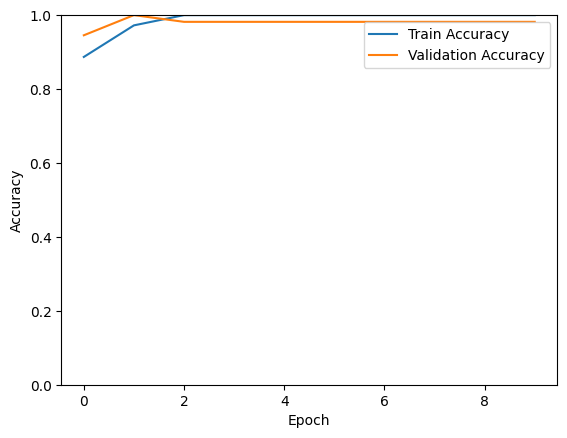

In [23]:
# Show the accuracy in the Training and Validation for each epoch
history = np.array(history)

plt.plot(history[:, 2:])
plt.legend(["Train Accuracy", "Validation Accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.show()

<h2 style="color:cornflowerblue">Prediction</h2>
<p>Creating a function to predict the class of a image with the best trained model. It's similat to the Validation: forward pass in the Neural Network, without updating the gradients or the Network parâmeters.</p>

In [24]:
def predict_function(testing_img):
    '''
    Function to predict the class
    Parameters:
        :param testing_img: image already transformed by PIL
    '''

    transform_img = img_transformation["test"]

    tensor_img_test = transform_img(testing_img)

    # if using a NVIDIA or certain PyTorch versions for GPU instead of CPU:
    if torch.cuda.is_available():
        tensor_img_test = tensor_img_test.view(1, 3, img_size, img_size).cuda()
    else:
        tensor_img_test = tensor_img_test.view(1, 3, img_size, img_size)

    dict_predictions = dict()

    # Gradients will not be calculated
    with torch.no_grad():
        trained_model.eval()

        # Model predictions (log)
        pred_log = trained_model(tensor_img_test)

        # Model predictions
        predictions = torch.exp(pred_log)

        # Dictionary of predictions
        dict_predictions = {class_dict[class_category]: float(predictions[0][class_category]) for class_category in range(class_num)}

    return dict_predictions

<h3 style="color:cornflowerblue">Prediction with a Test Image</h3>
<p>Preate predictions using the images in the test base and calculate the model accuracy.</p>

'carrot'

'lemon'

'potato'

'tomato'

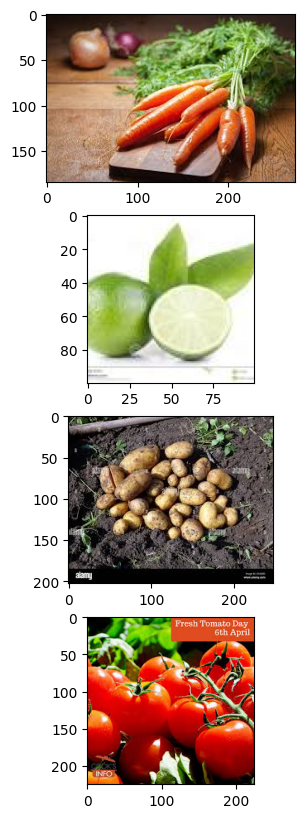

In [25]:
# Testing each class
fig, plots = plt.subplots(nrows=class_num, ncols=1, figsize=(5,10))

for i, c in enumerate(folders_img):
    test_folder = os.path.join(path_test, c)
    img = os.path.join(test_folder, os.listdir(test_folder)[0])
    img_test = PIL.Image.open(img)

    plots[i].imshow(img_test)

    prediction = predict_function(img_test)

    display(max(prediction, key = prediction.get))



<h3 style="color:cornflowerblue">Predictions Accuracy</h3>


In [26]:
def final_accuracy(test_folder):
    right_predictions = 0
    total_images = 0

    for c in os.listdir(test_folder):
        full_folder = os.path.join(test_folder, c)
        total_images += len(os.listdir(full_folder))

        for image in os.listdir(full_folder):
            img = os.path.join(full_folder, image)
            img_test = PIL.Image.open(img)
            predictions = predict_function(img_test)
            prediction = max(predictions, key=predictions.get)

            if prediction == c:
                right_predictions += 1
    
    return right_predictions*100/total_images

In [27]:
# Testing model accuracy in testing
final_accuracy(path_test)

96.49122807017544

<h2 style="color:cornflowerblue">Model Deploy</h2>
<p>Deploying

In [28]:
interface_gradio = gr.Interface(fn = predict_function,
                                inputs = gr.Image(type="pil"),
                                outputs = "label")

interface_gradio.launch(share=True, server_port=8080)

Running on local URL:  http://127.0.0.1:8080

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.


2023/12/25 09:17:35 [W] [service.go:132] login to server failed: dial tcp 44.237.78.176:7000: connectex: An attempt was made to access a socket in a way forbidden by its access permissions.
